#### Reading in dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV,\
cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import tree 
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

sns.set_style('whitegrid')

# Modeling the NBA Leap

This project applies machine learning classification to predict whether NBA players will make 'All NBA' teams in seasons 4 - 6, based upon thier first 3 season statistics. The structure of our model will be based upon inference, as the goal is to educate front offices on what player statistics correlate the most with future NBA stars. The model will focus on the 'precision' metric as we are aiming to minimize our false positives (predicting an NBA star when the player is not.)

## Defining 'The Leap'

“A player’s identity typically begins to crystallize in his third or fourth NBA season. Young players have learned the ropes, and veterans have departed or aged, vacating heavy-duty roles that need filling. Everyone involved — players, agents, executives — looks to see what emerges as a player nears the expiration of his rookie contract.” - Zach Lowe


## Business Problem

Each year 60 NBA players are drafted into the league and many others are signed as non-drafted free agents. Dependent on what round players are drafted in, rookie contracts can stretch from 2 to 4 years, with team options in the 3rd and 4th year. Its imperative for NBA front offices to be able identify if their recently drafted players will make the leap from productive NBA player to All NBA star.

Why is this important? Salary cap for the NBA in 2020-21 season is at $109M and first round draft picks who sign a 'max rookie scale extension' at the end of thier rookie deal can demand contracts up to 25% of the salary cap. Meaning its so important to correctly identify these players, as you don't want such a large percentage of your team's salary cap tied to a player who is not living up to expectations.

## Data

Data acquisition and compiling can be found in seperate notebooks saved [here.](https://github.com/rylewww/Modeling-The-NBA-Leap/tree/main/Notebooks)

I used Selenium webdriver to scrape both 'standard' and 'advanced' seasonal statistics of all NBA players dating back to 1947 from stathead.com. I then merged datasets containing NBA draft history, All NBA selections, All Rookie teams and All Defensive teams and began to aggregate all data down to one row representing the first 3 years of a players career. Our target is binary, '1' representing a player who was selected to an All NBA team in years 4-6, and '0' for those who were not.


In [6]:
#Reading in full non-aggregated data set for EDA
full_df = pd.read_csv('Data/Final_NBA_PLayers_updated.csv', index_col = 0)
#Reading in compiled 1-3 season data set
df_final = pd.read_csv('Data/Final_NBA_Seasons1-3_1977_final.csv', index_col = 0)
df_final.set_index('Player', inplace = True)
df_final.head()

G     GS      MP   FG   FGA   2P   2PA     3P  \
Player                                                                    
A.C. Green\greenac01    243  137.0  6418.0  847  1615  846  1602    1.0   
A.J. Price\priceaj01    150    3.0  2228.0  318   848  191   437  127.0   
Aaron Brooks\brookaa01  213  117.0  5525.0  984  2339  626  1396  358.0   
Aaron Gordon\gordoaa01  205  117.0  4958.0  760  1652  628  1195  132.0   
Aaron Gray\grayaa01     149   19.0  1639.0  226   453  226   451    0.0   

                          3PA   FT  ...  DWS_1-2  DWS_2-3  PER_1-2  PER_2-3  \
Player                              ...                                       
A.C. Green\greenac01     13.0  615  ...      1.3      0.1      3.9     -1.2   
A.J. Price\priceaj01    411.0  142  ...     -0.1     -0.2     -3.3      0.8   
Aaron Brooks\brookaa01  943.0  436  ...      1.4     -0.6     -0.2      3.1   
Aaron Gordon\gordoaa01  457.0  329  ...      1.5     -0.5      5.6     -2.5   
Aaron Gray\grayaa01       2.0  110  ...      0.0     -0.4     -2.4      5.1   

                        USG_1-2  USG_2-3  VORP_1-2  VORP_2-3  target  \
Player                                                                 
A.C. Green\greenac01        0.0      0.0       1.5      -0.2       0   
A.J. Price\priceaj01        0.0     -5.0      -0.5       0.3       0   
Aaron Brooks\brookaa01      1.1      2.8       0.3       1.3       0   
Aaron Gordon\gordoaa01      1.8      2.8       1.6      -0.8       0   
Aaron Gray\grayaa01        -7.5      1.9       0.0       0.3       0   

                        Qualified  
Player                             
A.C. Green\greenac01          1.0  
A.J. Price\priceaj01          1.0  
Aaron Brooks\brookaa01        1.0  
Aaron Gordon\gordoaa01        1.0  
Aaron Gray\grayaa01           1.0  

[5 rows x 216 columns]

Final Data Set was subset to players who's rookie year was 1977 and later, advanced statistics such as Win-Share and VORP were not tracked prior to 1977. Furthermore, qualified players need to play a minumum of six years in the league as our target variable is All NBA selections in seasons 4 through 6. This left us with the following population breakdown:

([<matplotlib.axis.XTick at 0x7f83877d4fd0>,
 [Text(0, 0, 'Not All NBA'), Text(1, 0, 'All NBA')])

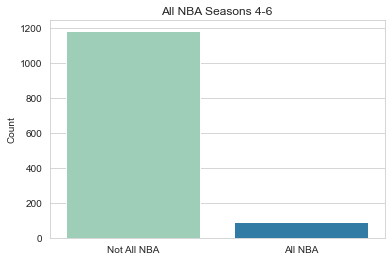

In [17]:
sns.barplot(x = df_final['target'].value_counts().index, y = df_final['target'].value_counts(), palette = 'YlGnBu')
plt.title('All NBA Seasons 4-6')
plt.ylabel('Count')
plt.xticks([0,1],['Not All NBA', 'All NBA'])

## Exploratory Data Analysis

Once the data was properly formatted and cleaned, I began to explore and investigate which features correlated the most with our 'All NBA 4-6' target variable. It became clear that future All NBA players differentiate themselves from the rest of the league with statistic totals in the first three years.

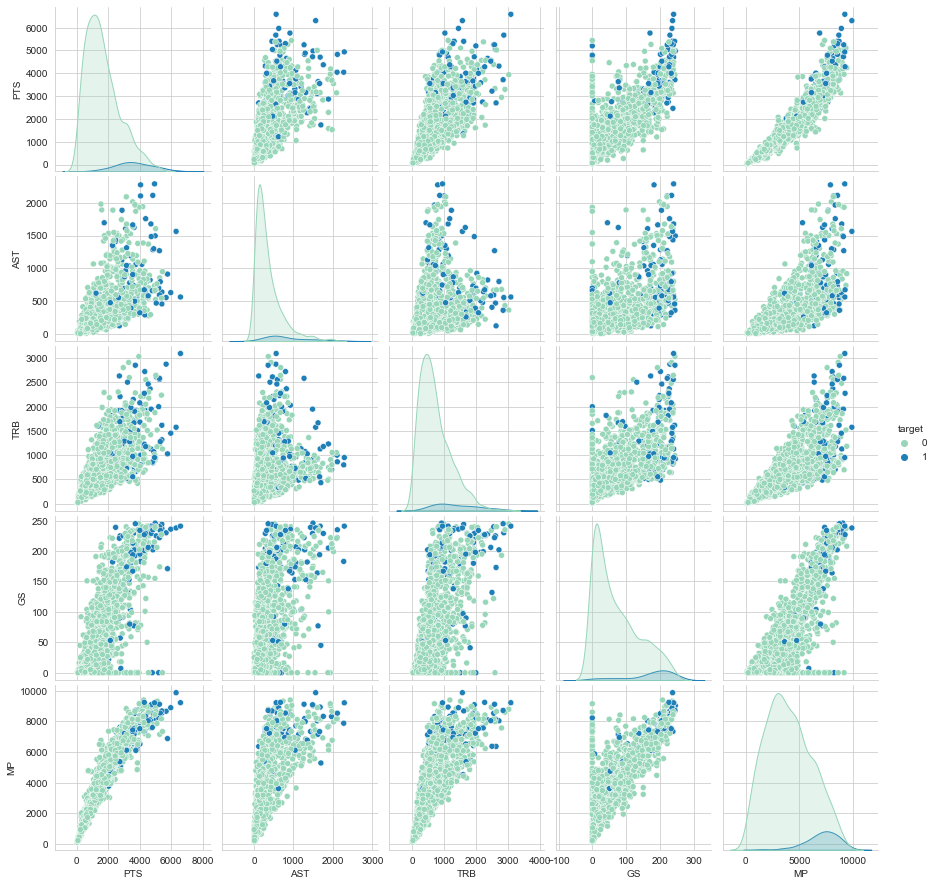

In [18]:
pair_plt_stats = df_final[['PTS','AST','TRB','GS', 'MP','target']]

sns.pairplot(pair_plt_stats, hue = 'target', palette = 'YlGnBu')

# plt.savefig('nba_pair_plt_basic.png')
plt.show();

The following pairplots show the relationship between advanced statistics and thier relationship with our target variable over the first 3 seasons of an NBA players career. All NBA players visually begin to differntiate themselves from the rest of the league in seasons 2 and 3.

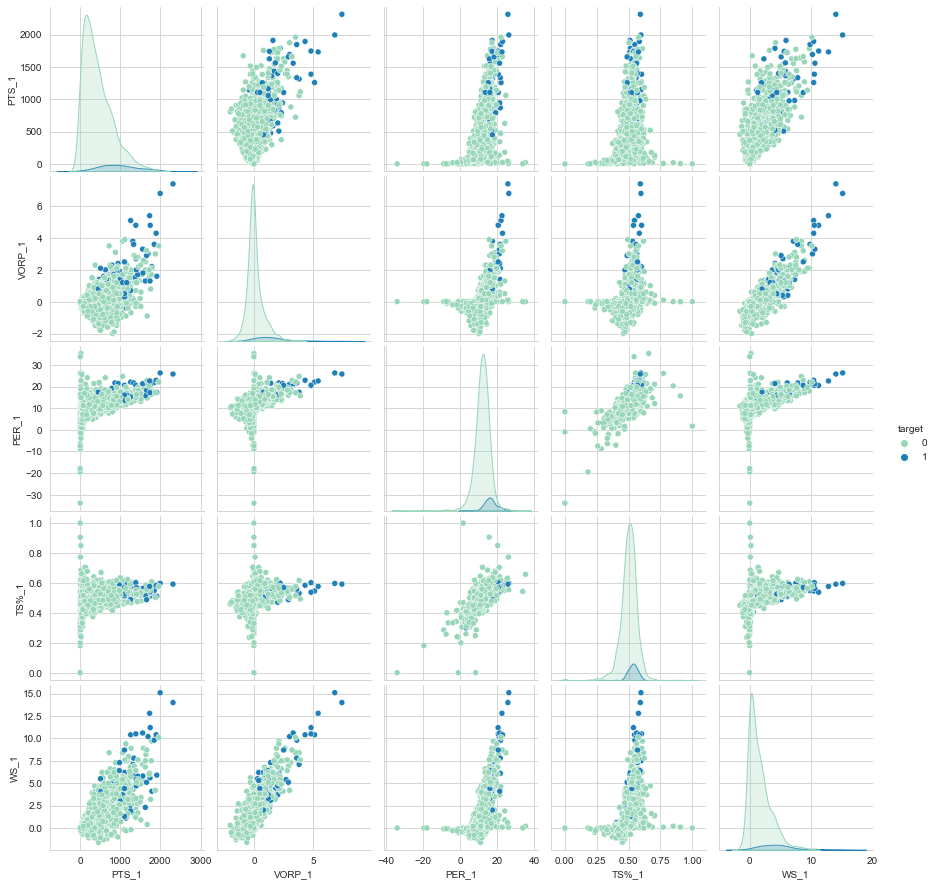

In [20]:
pair_plt_stats = df_final[['PTS_1','VORP_1','PER_1','TS%_1','WS_1','target']]

sns.pairplot(pair_plt_stats, hue = 'target', palette = 'YlGnBu')

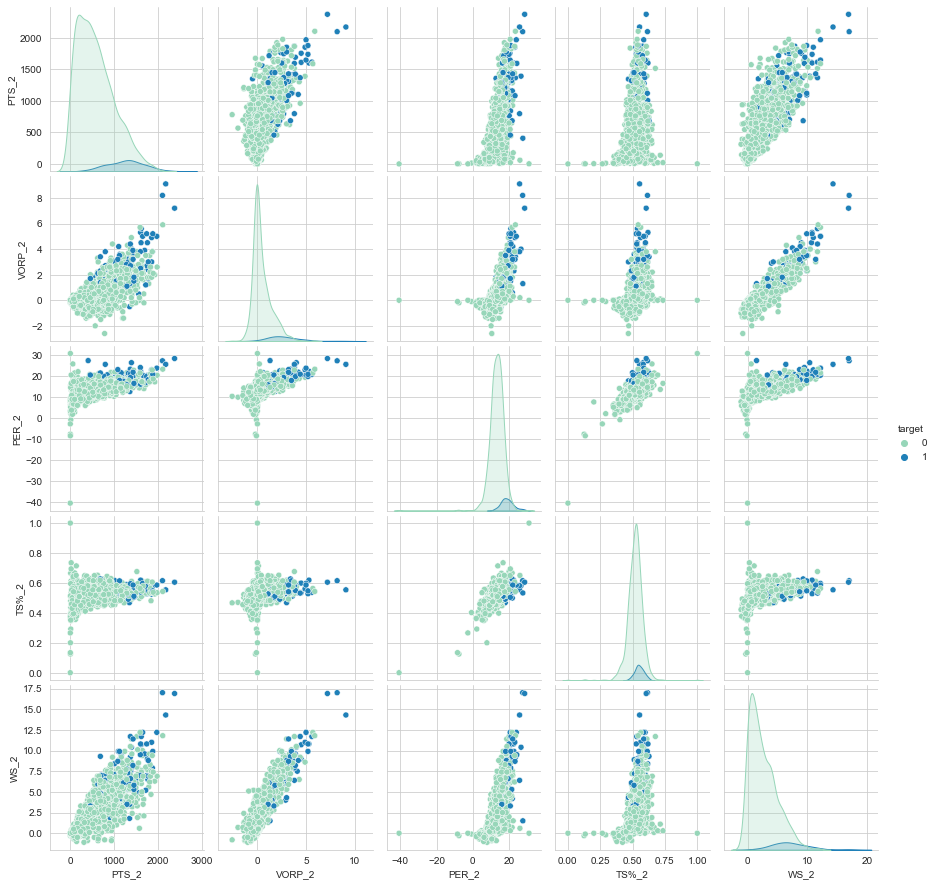

In [21]:
pair_plt_stats = df_final[['PTS_2','VORP_2','PER_2','TS%_2','WS_2','target']]

sns.pairplot(pair_plt_stats, hue = 'target', palette = 'YlGnBu')

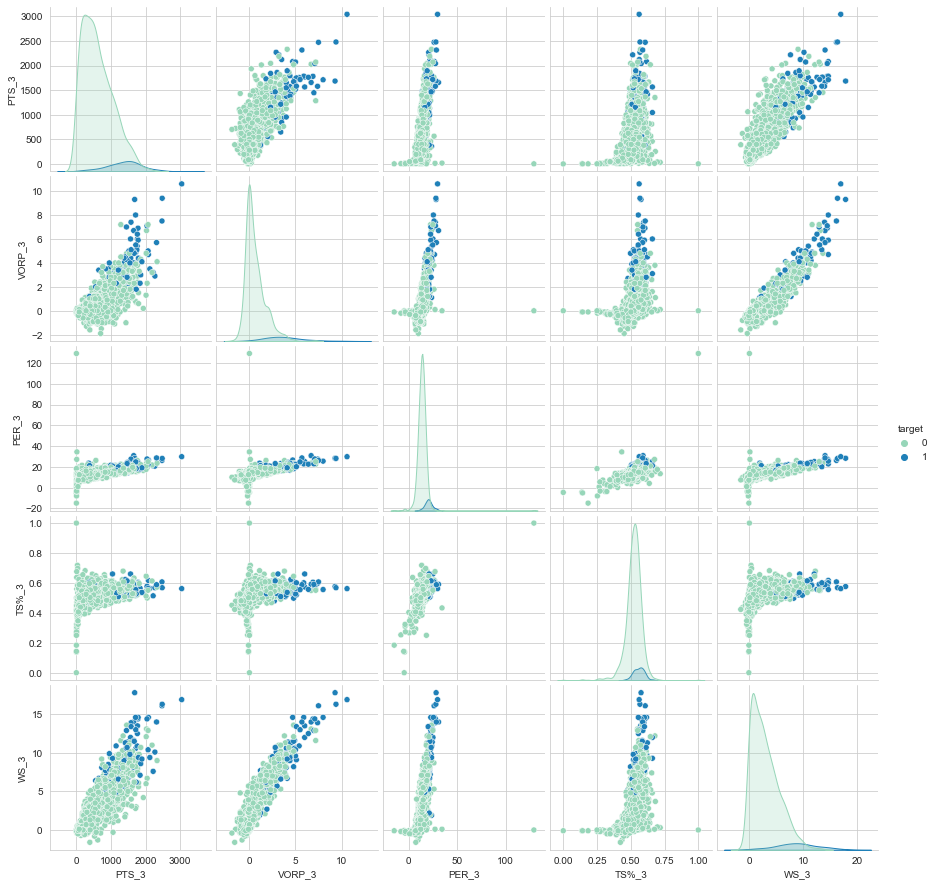

In [19]:
pair_plt_stats = df_final[['PTS_3','VORP_3','PER_3','TS%_3','WS_3','target']]

sns.pairplot(pair_plt_stats, hue = 'target', palette = 'YlGnBu')

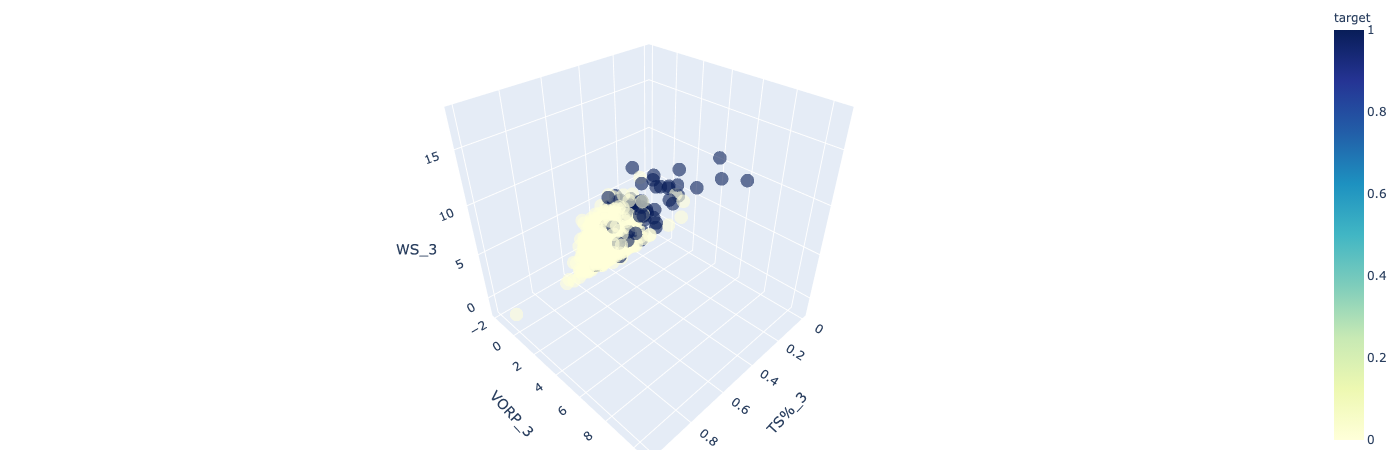

In [22]:
fig = px.scatter_3d(df_final, x='TS%_3', y='VORP_3', z='WS_3', color='target', size_max=10, opacity=0.6,\
                   color_continuous_scale='YlGnBu')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Feature Engineering

The majority of my feature engineering was done during my dataset compiling. 

Continuous features include:
* Per game statistics
* Year 2 v Year 1 increase/decrease
* Year 3 v Year 2 increase/decrease

Categorical features include:
* Rookie of the Year awards
* All Defensive Selections
* Categorical statistic improvements over each season


In [23]:
#YoY categorial variable increases
df_final['VORP_Incr'] = np.where((df_final['VORP_1-2'] > 0) & (df_final['VORP_2-3'] > 0),1,0) 
df_final['PER_Incr'] = np.where((df_final['PER_1-2'] > 0) & (df_final['PER_2-3'] > 0),1,0) 
df_final['USG_Incr'] = np.where((df_final['USG_1-2'] > 0) & (df_final['USG_2-3'] > 0),1,0)
df_final['WS_Incr'] = np.where((df_final['WS_1-2'] > 0) & (df_final['WS_2-3'] > 0),1,0)
df_final['PPG_Incr'] = np.where((df_final['PPG_1-2'] > 0) & (df_final['PPG_2-3'] > 0),1,0)

### Correlation Plot

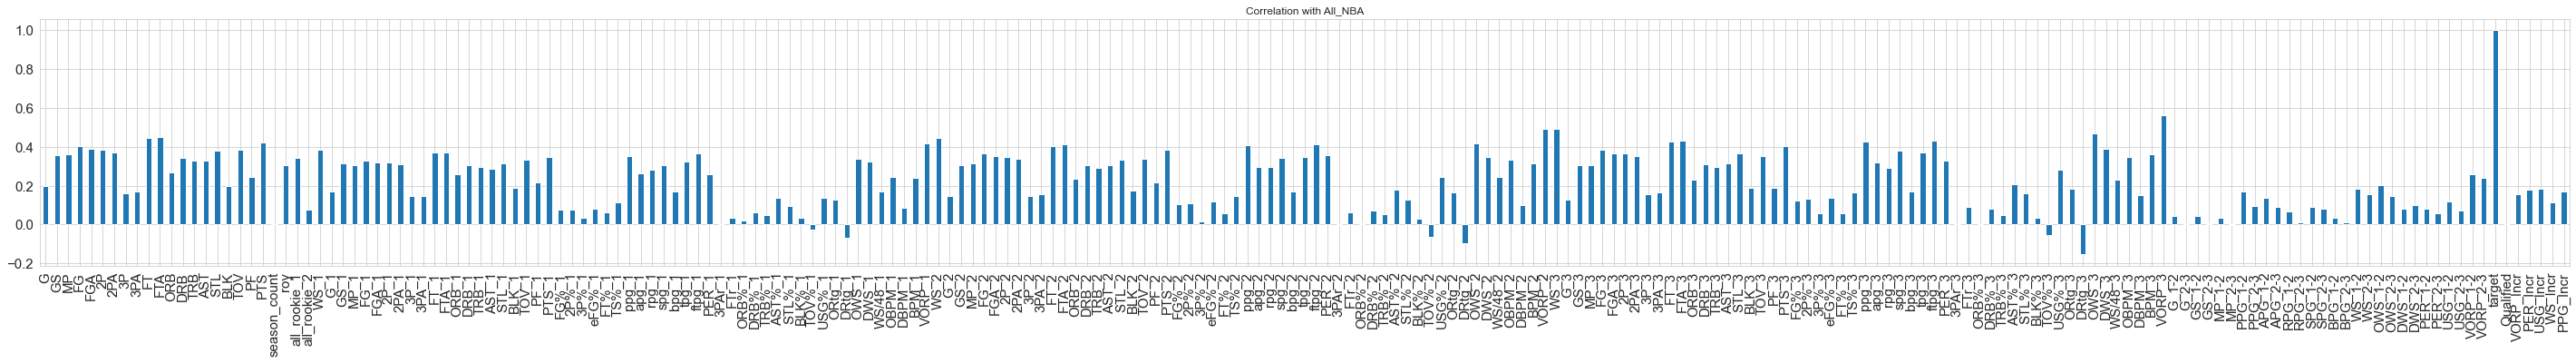

In [24]:
df_final.corrwith(df_final.target).plot.bar(figsize = (50, 5), title = "Correlation with All_NBA", 
                                        fontsize = 15,rot = 90, grid = True);

After cleaning our dataset and adding our newly created feature engineering - we were left with over 200 features to work with. This many features can lead to overfitting models on the training data set, so we will need to reduce our dimensionality using recursive feature elimination.

## Recursive Feature Elimination

After reducing the number of features down with correlation analysis, I was left with the following columns:

In [32]:
cols = ['MP','FG','2P','FT','TRB','AST','STL','TOV','PTS','roy','all_rookie_1','all_rookie_2','WS_1','GS_1','MP_1','PTS_1','ppg_1','apg_1','rpg_1','spg_1','bpg_1',
        'tpg_1','ftpg_1','PER_1','WS/48_1','VORP_1','WS_2','GS_2','MP_2','ppg_2','apg_2','rpg_2','spg_2','bpg_2','tpg_2','ftpg_2','PER_2','USG%_2',
        'ORtg_2','DRtg_2','OWS_2','DWS_2','WS/48_2','VORP_2','WS_3','GS_3','MP_3','PTS_3','TS%_3','ppg_3','apg_3','rpg_3','spg_3','bpg_3','tpg_3','ftpg_3','PER_3','USG%_3',
        'ORtg_3','DRtg_3','OWS_3','DWS_3','WS/48_3','VORP_3','target',]

df = df_final[cols]
df = df.fillna(0)
df.head()

MP   FG   2P   FT     TRB  AST    STL    TOV  \
Player                                                                     
A.C. Green\greenac01    6418.0  847  846  615  1706.0  231  206.0  321.0   
A.J. Price\priceaj01    2228.0  318  191  142   221.0  303   84.0  144.0   
Aaron Brooks\brookaa01  5525.0  984  626  436   428.0  759  128.0  401.0   
Aaron Gordon\gordoaa01  4958.0  760  628  329  1081.0  311  145.0  193.0   
Aaron Gray\grayaa01     1639.0  226  226  110   494.0  109   44.0  115.0   

                         PTS  roy  ...    ftpg_3  PER_3  USG%_3  ORtg_3  \
Player                             ...                                    
A.C. Green\greenac01    2310  0.0  ...  3.573171   14.5    14.7   119.0   
A.J. Price\priceaj01     905  0.0  ...  0.636364   11.5    17.7   100.0   
Aaron Brooks\brookaa01  2762  0.0  ...  2.987805   16.0    25.7   108.0   
Aaron Gordon\gordoaa01  1981  0.0  ...  1.950000   14.5    20.1   107.0   
Aaron Gray\grayaa01      562  0.0  ...  0.625000   16.6    16.4   115.0   

                        DRtg_3  OWS_3  DWS_3  WS/48_3  VORP_3  target  
Player                                                                 
A.C. Green\greenac01     106.0    4.5    3.4    0.144     1.5       0  
A.J. Price\priceaj01     106.0    0.2    0.5    0.063     0.1       0  
Aaron Brooks\brookaa01   112.0    3.9    1.6    0.091     1.9       0  
Aaron Gordon\gordoaa01   111.0    2.0    1.7    0.077     0.6       0  
Aaron Gray\grayaa01      106.0    0.5    0.4    0.142     0.1       0  

[5 rows x 65 columns]

I then applied recursive feature elimination to further reduce the dimensionality of our data set

In [33]:
#Train-test-split
X = df.drop(columns = 'target')
y = df['target']

X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 42)

In [34]:
nba_scaled = StandardScaler()

nba_scaled.fit(X_train)
X_train_sc = pd.DataFrame(nba_scaled.transform(X_train), index = X_train.index, columns = X_train.columns)
X_test_sc = pd.DataFrame(nba_scaled.transform(X_test), index = X_test.index, columns = X_test.columns)

In [35]:
rfe_lr = RFECV(estimator=LogisticRegression(class_weight = 'balanced', max_iter = 1000), step = 1, cv = 3, scoring = 'precision', n_jobs = -1, verbose = 1)
rfe_lr.fit(X_train_sc, y_train)
X_train_sc.columns[rfe_lr.get_support()]

Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 fe

Index(['2P', 'TRB', 'PTS', 'spg_1', 'ppg_2', 'PER_2', 'MP_3', 'PTS_3', 'TS%_3',
       'spg_3', 'PER_3', 'VORP_3'],
      dtype='object')

In [36]:
#final columns based on recursive feature elimination
final_cols = ['2P', 'TRB', 'PTS', 'spg_1', 'ppg_2', 'PER_2', 'MP_3', 'PTS_3', 'TS%_3',
       'spg_3', 'PER_3', 'VORP_3']

## Modeling

in efforts to best understand what statistics highlight young NBA players potential growth to All NBA stars, the models I focused on were all interpretable. Additionally, they were all grid-searched to best tune our hyperparameters and scored based on the 'precision' metric to reduce our false positives.

In [37]:
# create function to call for evaluation of each model

def metrics_score(train_preds, y_train, test_preds, y_test):
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")
    print(f"Training Precision:\t{precision_score(y_train, train_preds):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds):.4}")
    print(f"Training Recall:\t{recall_score(y_train, train_preds):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds):.4}")
    print(f"Training F1:\t\t{f1_score(y_train, train_preds):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds):.4}")

In [38]:
ss = StandardScaler()
train_scaled = ss.fit_transform(X_train[final_cols])
test_scaled = ss.transform(X_test[final_cols])

scorer = make_scorer(precision_score)

### Logistic Regression 

In [39]:
C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100])

logistic = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

grid_search_LR = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                              cv = 3, n_jobs = -1, verbose = 2)

In [40]:
grid_search_LR.fit(train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.1s finished


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(precision_score), verbose=2)

In [41]:
lr_train_preds = grid_search_LR.best_estimator_.predict(train_scaled)
lr_test_preds = grid_search_LR.best_estimator_.predict(test_scaled)
metrics_score(lr_train_preds, y_train, lr_test_preds, y_test)

Training Accuracy:	0.9008 	Testing Accuracy:	0.8941
Training Precision:	0.411 	Testing Precision:	0.3846
Training Recall:	0.9306 	Testing Recall:		0.8333
Training F1:		0.5702 	Testing F1:		0.5263


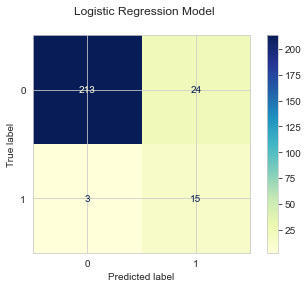

In [42]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression Model")

plot_confusion_matrix(grid_search_LR, test_scaled, y_test, ax=ax, cmap="YlGnBu");

### Logistic Regression w/ SMOTE Resampling

In [43]:
sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_sample(train_scaled, y_train.ravel())

C = np.logspace(0, 1, 10)

params = dict(C=C, max_iter=[50, 100])

logistic = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

grid_search_LR_sm = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = params, 
                              cv = 3, n_jobs = -1, verbose = 2)
grid_search_LR_sm.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(precision_score), verbose=2)

In [44]:
lr_train_preds_sm = grid_search_LR_sm.best_estimator_.predict(X_train_res)
lr_test_preds_sm = grid_search_LR_sm.best_estimator_.predict(test_scaled)
metrics_score(lr_train_preds_sm, y_train_res, lr_test_preds_sm, y_test)

Training Accuracy:	0.9286 	Testing Accuracy:	0.8863
Training Precision:	0.9168 	Testing Precision:	0.359
Training Recall:	0.9429 	Testing Recall:		0.7778
Training F1:		0.9297 	Testing F1:		0.4912


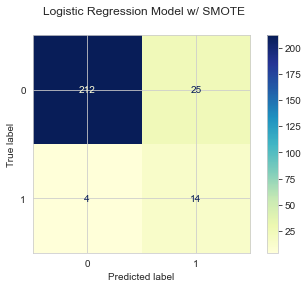

In [45]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression Model w/ SMOTE")

plot_confusion_matrix(grid_search_LR_sm, test_scaled, y_test, ax=ax, cmap="YlGnBu");

### Random Forest Model

In [46]:
params = { 
    'n_estimators': [10, 25, 50, 100, 200, 500],
    'max_features': ['sqrt', 'auto', 'log2'],
    'max_depth' : [2,4,6,8,10,12,15,20],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state = 42)

grid_search_RF = GridSearchCV(estimator=rf, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

In [47]:
grid_search_RF.fit(train_scaled, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 385 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1033 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 15, 20],
                         'max_features': ['sqrt', 'auto', 'log2'],
                         'n_estimators': [10, 25, 50, 100, 200, 500]},
             scoring=make_scorer(precision_score), verbose=2)

In [48]:
grid_search_RF.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 'sqrt',
 'n_estimators': 10}

In [49]:
rf_train_preds = grid_search_RF.best_estimator_.predict(train_scaled)
rf_test_preds = grid_search_RF.best_estimator_.predict(test_scaled)
metrics_score(rf_train_preds, y_train, rf_test_preds, y_test)

Training Accuracy:	0.9479 	Testing Accuracy:	0.9451
Training Precision:	0.8276 	Testing Precision:	0.75
Training Recall:	0.3333 	Testing Recall:		0.3333
Training F1:		0.4752 	Testing F1:		0.4615


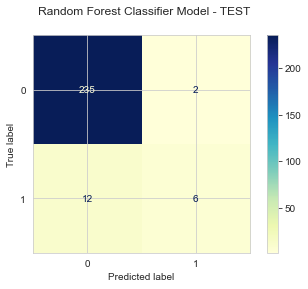

In [51]:
fig, ax = plt.subplots()

fig.suptitle("Random Forest Classifier Model - TEST")

plot_confusion_matrix(grid_search_RF, test_scaled, y_test, ax=ax, cmap="YlGnBu");

### Random Forest w/ SMOTE Resampling

In [52]:
params = { 
    'n_estimators': [10, 25, 50, 100, 200, 500],
    'max_features': ['sqrt', 'auto', 'log2'],
    'max_depth' : [2,4,6,8,10,12,15,20],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state = 42)

grid_search_RF_sm = GridSearchCV(estimator=rf, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

grid_search_RF_sm.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 385 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1033 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 15, 20],
                         'max_features': ['sqrt', 'auto', 'log2'],
                         'n_estimators': [10, 25, 50, 100, 200, 500]},
             scoring=make_scorer(precision_score), verbose=2)

In [53]:
grid_search_RF_sm.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 10}

In [54]:
rf_train_preds_sm = grid_search_RF_sm.best_estimator_.predict(X_train_res)
rf_test_preds_sm = grid_search_RF_sm.best_estimator_.predict(test_scaled)
metrics_score(rf_train_preds_sm, y_train_res, rf_test_preds_sm, y_test)

Training Accuracy:	0.9968 	Testing Accuracy:	0.9255
Training Precision:	0.9989 	Testing Precision:	0.4762
Training Recall:	0.9947 	Testing Recall:		0.5556
Training F1:		0.9968 	Testing F1:		0.5128


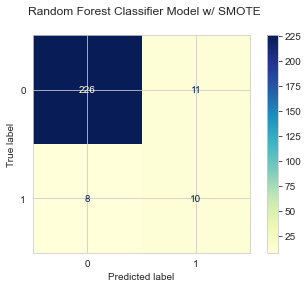

In [55]:
fig, ax = plt.subplots()

fig.suptitle("Random Forest Classifier Model w/ SMOTE")

plot_confusion_matrix(grid_search_RF_sm, test_scaled, y_test, ax=ax, cmap="YlGnBu");

### Decision Tree Model

In [56]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

params = dict(criterion=['gini', 'entropy'],
                max_depth=[2,4,6,8,10,12,15,20,25],
                 splitter = ['best', 'random'],
             )

DT = tree.DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')

grid_search_DT = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

In [57]:
grid_search_DT.fit(train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.3s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 15, 20, 25],
                         'splitter': ['best', 'random']},
             scoring=make_scorer(precision_score), verbose=2)

In [58]:
grid_search_DT.best_params_

{'criterion': 'gini', 'max_depth': 12, 'splitter': 'best'}

In [59]:
dt_train_preds = grid_search_DT.best_estimator_.predict(train_scaled)
dt_test_preds = grid_search_DT.best_estimator_.predict(test_scaled)
metrics_score(dt_train_preds, y_train, dt_test_preds, y_test)

Training Accuracy:	0.9833 	Testing Accuracy:	0.8941
Training Precision:	0.809 	Testing Precision:	0.3333
Training Recall:	1.0 	Testing Recall:		0.5
Training F1:		0.8944 	Testing F1:		0.4


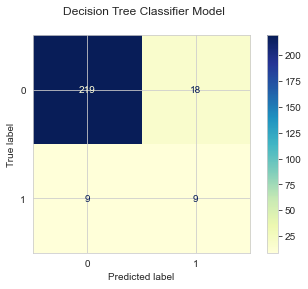

In [60]:
fig, ax = plt.subplots()

fig.suptitle("Decision Tree Classifier Model")

plot_confusion_matrix(grid_search_DT, test_scaled, y_test, ax=ax, cmap="YlGnBu");

### Decision Tree w/ SMOTE Resampling

In [61]:
params = dict(criterion=['gini', 'entropy'],
                max_depth=[2,4,6,8,10,12,15,20,25],
                 splitter = ['best', 'random'],
             )

DT = tree.DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')


grid_search_DT_sm = GridSearchCV(estimator=DT, param_grid=params, scoring=scorer, 
                              cv = 5, n_jobs = -1, verbose = 2)

grid_search_DT_sm.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.9s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 15, 20, 25],
                         'splitter': ['best', 'random']},
             scoring=make_scorer(precision_score), verbose=2)

In [62]:
grid_search_DT_sm.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'splitter': 'random'}

In [63]:
dt_train_preds_sm = grid_search_DT_sm.best_estimator_.predict(X_train_res)
dt_test_preds_sm = grid_search_DT_sm.best_estimator_.predict(test_scaled)
metrics_score(dt_train_preds_sm, y_train_res, dt_test_preds_sm, y_test)

Training Accuracy:	0.9958 	Testing Accuracy:	0.9098
Training Precision:	0.9979 	Testing Precision:	0.3913
Training Recall:	0.9937 	Testing Recall:		0.5
Training F1:		0.9958 	Testing F1:		0.439


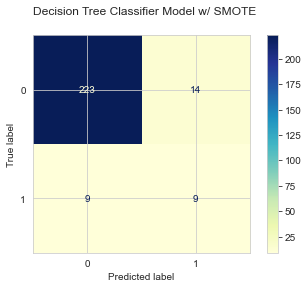

In [64]:
fig, ax = plt.subplots()

fig.suptitle("Decision Tree Classifier Model w/ SMOTE")

plot_confusion_matrix(grid_search_DT_sm, test_scaled, y_test, ax=ax, cmap="YlGnBu");

## Results

In [66]:
model_candidates = [
    
    {'name':'Logistic Regression',
     'accuracy score':accuracy_score(y_test, lr_test_preds),
     'recall score' : recall_score(y_test, lr_test_preds),
     'precision score' : precision_score(y_test,lr_test_preds),
         'f1 score':metrics.f1_score(y_test, lr_test_preds)},
    
    {'name':'Logistic Regression w/ SMOTE',
     'accuracy score':accuracy_score(y_test, lr_test_preds_sm),
     'recall score' : recall_score(y_test, lr_test_preds_sm),
     'precision score' : precision_score(y_test,lr_test_preds_sm),
     'f1 score':metrics.f1_score(y_test, lr_test_preds_sm)},
    
    {'name':'Random Forest',
     'accuracy score':accuracy_score(y_test, rf_test_preds),
     'recall score' : recall_score(y_test, rf_test_preds,),
     'precision score' : precision_score(y_test,rf_test_preds),
    'f1 score':metrics.f1_score(y_test, rf_test_preds)},
    
    {'name':'Random Forest w/ SMOTE',
     'accuracy score':accuracy_score(y_test, rf_test_preds_sm),
     'recall score' : recall_score(y_test, rf_test_preds_sm),
     'precision score' : precision_score(y_test,rf_test_preds_sm),
     'f1 score':metrics.f1_score(y_test, dt_test_preds)},
    
    {'name':'Decision Tree',
     'accuracy score':accuracy_score(y_test, dt_test_preds),
     'recall score' : recall_score(y_test, dt_test_preds),
     'precision score' : precision_score(y_test,dt_test_preds),
     'f1 score':metrics.f1_score(y_test, dt_test_preds)},
    
    {'name':'Decision Tree w/ SMOTE',
     'accuracy score':accuracy_score(y_test, dt_test_preds_sm),
     'recall score' : recall_score(y_test, dt_test_preds_sm),
     'precision score' : precision_score(y_test,dt_test_preds_sm),
     'f1 score':metrics.f1_score(y_test, dt_test_preds_sm)},
    
]

final_scores_df = pd.DataFrame(model_candidates).set_index('name')
final_scores_df

accuracy score  recall score  precision score  \
name                                                                          
Logistic Regression                 0.894118      0.833333         0.384615   
Logistic Regression w/ SMOTE        0.886275      0.777778         0.358974   
Random Forest                       0.945098      0.333333         0.750000   
Random Forest w/ SMOTE              0.925490      0.555556         0.476190   
Decision Tree                       0.894118      0.500000         0.333333   
Decision Tree w/ SMOTE              0.909804      0.500000         0.391304   

                              f1 score  
name                                    
Logistic Regression           0.526316  
Logistic Regression w/ SMOTE  0.491228  
Random Forest                 0.461538  
Random Forest w/ SMOTE        0.400000  
Decision Tree                 0.400000  
Decision Tree w/ SMOTE        0.439024

The Random Forest model produced the best results with an Accuracy score og 94.5% and a Precision score of 75%. Below shows  which features the model found most important when identifying future All NBA players.

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.01455
Feature: 2, Score: 0.24849
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.07240
Feature: 5, Score: 0.17203
Feature: 6, Score: 0.01067
Feature: 7, Score: 0.15115
Feature: 8, Score: 0.01192
Feature: 9, Score: 0.05250
Feature: 10, Score: 0.08882
Feature: 11, Score: 0.17748


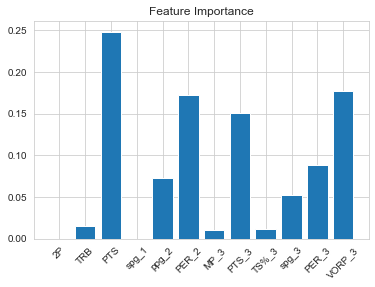

In [67]:
importance = grid_search_RF.best_estimator_.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],['2P', 'TRB', 'PTS', 'spg_1', 'ppg_2', 'PER_2', 'MP_3', 'PTS_3', 'TS%_3',
       'spg_3', 'PER_3', 'VORP_3'], rotation = 45)
plt.title('Feature Importance')
plt.show()

# Conclusion

Our Random Forest model performed the best per our business question of identifying and explaining which NBA players were expected to reach All NBA levels in seasons 4 through 6. It scored the highest precision score, meaning that when it identifies a player to be 'making the leap' its correct 75% of the time. It displays the importance a players points total and 3rd season VORP rating relates to the probability they will make an All NBA team in the next three seasons.



## Next Steps

There's plenty of room for improvement in our model, currently it has too high of standards to which it classifies future All NBA players. In the future I hope to add the following:

- Implement additional resampling techniques to better combat class imbalance

- Pull in additional categorial data such as draft pick positions and team win/loss records

- Look into generational trends; did All NBA players look statistically different in the 80's vs 90's

- Expanding into a multiclass classification model - breaking down All NBA teams or classifying All NBA vs All Defense

### Sources

* Seasonal & Advanced statistics webscraped from Stathead.com
* Team Awards such as All NBA/All Defense downloaded from ESPN.com